<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting the Density Estimator

In [1]:
## todo add forked repo as origin or upstream
## check paths
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#! pip install --user -e /global/u2/v/vboehm/codes/SIG_GIS/

In [3]:
import sys

In [4]:
sys.path.append('/global/u2/v/vboehm/codes/SIG_GIS/')

In [5]:
from sig_gis import *

In [6]:
from sig_gis.GIS import *

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'
root_prepped    = os.path.join(root_data,'sdss/prepped')

network_type    = 'fully_connected'
label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'
label_2         = label_+'_10_fully_connected'

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [9]:

encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s.npy'%label_2), allow_pickle=True)
decoded_train, decoded_valid, decoded_test = np.load(os.path.join(root_decoded,'decoded_%s.npy'%label_2), allow_pickle=True)

In [10]:
seed =8365

In [11]:
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device('cpu')

In [12]:
encoded_train = torch.tensor(encoded_train).to(device)
encoded_valid = torch.tensor(encoded_valid).to(device)

In [15]:
res_fluxes, res_masks, res_inv_vars = np.load(os.path.join(root_prepped,'prepped_data_spectra_%s.npy'%label_),allow_pickle=True)

redshifts, SNs, ras, decs, category, sublabel = np.load(os.path.join(root_prepped,'prepped_data_prop_%s.npy'%label_),allow_pickle=True)



In [16]:
mean=np.mean(res_fluxes)
print(mean)

225519.1514153083


In [17]:

DATASET_SIZE = len(res_fluxes)
train_size   = int(0.6 * DATASET_SIZE)
test_size    = int(0.2 * DATASET_SIZE)
valid_size   = int(0.2 * DATASET_SIZE)

In [20]:
train_data   = np.expand_dims(res_fluxes[:train_size],-1)/mean
valid_data   = np.expand_dims(res_fluxes[train_size:train_size+valid_size],-1)/mean
test_data    = np.expand_dims(res_fluxes[-test_size::],-1)/mean

train_mask   = np.expand_dims(res_masks[:train_size],-1)
valid_mask   = np.expand_dims(res_masks[train_size:train_size+valid_size],-1)
test_mask    = np.expand_dims(res_masks[-test_size::],-1)

train_noise  = np.expand_dims(res_inv_vars[:train_size],-1)*mean**2
valid_noise  = np.expand_dims(res_inv_vars[train_size:train_size+valid_size],-1)*mean**2
test_noise   = np.expand_dims(res_inv_vars[-test_size::],-1)*mean**2

train_params = np.asarray(redshifts, dtype=np.float32)[:train_size]
valid_params = np.asarray(redshifts, dtype=np.float32)[train_size:train_size+valid_size]
test_params = np.asarray(redshifts, dtype=np.float32)[-test_size::]

train_ras = np.asarray(ras, dtype=np.float32)[:train_size]
valid_ras = np.asarray(ras, dtype=np.float32)[train_size:train_size+valid_size]
test_ras = np.asarray(ras, dtype=np.float32)[-test_size::]

train_decs = np.asarray(decs, dtype=np.float32)[:train_size]
valid_decs = np.asarray(decs, dtype=np.float32)[train_size:train_size+valid_size]
test_decs = np.asarray(decs, dtype=np.float32)[-test_size::]

train_cat = category[:train_size]
valid_cat = category[train_size:train_size+valid_size]
test_cat = category[-test_size::]

train_labels = sublabel[:train_size]
valid_labels = sublabel[train_size:train_size+valid_size]
test_labels = sublabel[-test_size::]

In [21]:
try:
    model =  torch.load('GIS_%s_seed%d'%(label_2,seed))
except:
    model = train_GIS(encoded_train, data_validate=encoded_valid, alpha=torch.tensor((0.5,0.5)).to(device))

Fit A: Time: 0.7091394653320312 Wasserstein Distance: [0.4536377191543579, 0.449886679649353, 0.3942098021507263, 0.3844936192035675, 0.3666702210903168, 0.3602178394794464, 0.32355859875679016, 0.2792016267776489]
Fit spline Time: 0.09671405029296876
logp: -11.37358283996582 -11.395599365234375 time: 0.839343786239624 iteration: 1 best: 1
Fit A: Time: 0.8292321166992187 Wasserstein Distance: [0.4339716136455536, 0.4110700190067291, 0.34108880162239075, 0.31349053978919983, 0.31061843037605286, 0.2908596396446228, 0.2533436119556427, 0.1621716320514679]
Fit spline Time: 0.09803961944580078
logp: -10.079092979431152 -10.091801643371582 time: 0.9687342643737793 iteration: 2 best: 2
Fit A: Time: 0.8990924682617187 Wasserstein Distance: [0.3581637740135193, 0.3262571096420288, 0.3214186429977417, 0.284559965133667, 0.25017619132995605, 0.246171772480011, 0.19858644902706146, 0.19636878371238708]
Fit spline Time: 0.09697996520996094
logp: -9.043848037719727 -9.051118850708008 time: 1.036718

In [22]:
 #torch.save(model, 'GIS_%s_seed%d'%(label_2,seed))
model.evaluate_density(encoded_valid[0:100]).cpu()

tensor([  -32.7556,   -43.6311,   -26.4205,   -30.7148,   -50.9758,   -64.3316,
          -94.3759,   -25.2858,   -17.7320,   -21.4081,   -59.7896, -2905.3210,
          -25.6749,   -31.5214,   -24.2171,   -16.6398,   -72.9764, -1270.7401,
         -330.8895,   -28.6513,   -37.2709,   -19.9431,   -22.3201,   -26.9925,
          -21.7608,   -80.5371,   -42.0542,   -35.0389,  -189.4974,   -24.5179,
          -52.2472,  -214.2796,   -24.9856,   -28.1099,   -55.5397,   -41.0724,
         -115.1221,   -25.1538,   -19.3021,   -35.6413,  -103.5754,   -36.6028,
          -13.6916,   -32.3377,   -42.8949,   -39.5865,   -20.0296,   -14.4779,
          -86.7592,   -81.3524,   -28.9574,   -86.2910,   -34.3855,   -31.2777,
          -86.0079,   -45.8303,   -48.2147,   -89.3024,  -259.6582,   -38.6486,
          -32.1436,  -237.2367,   -28.2470,  -195.4578,   -79.2989,   -29.4856,
          -37.9207,   -46.9398,   -32.2512,  -140.4849,   -18.9472,   -82.8265,
        -3091.3318,   -62.7217,   -30.47

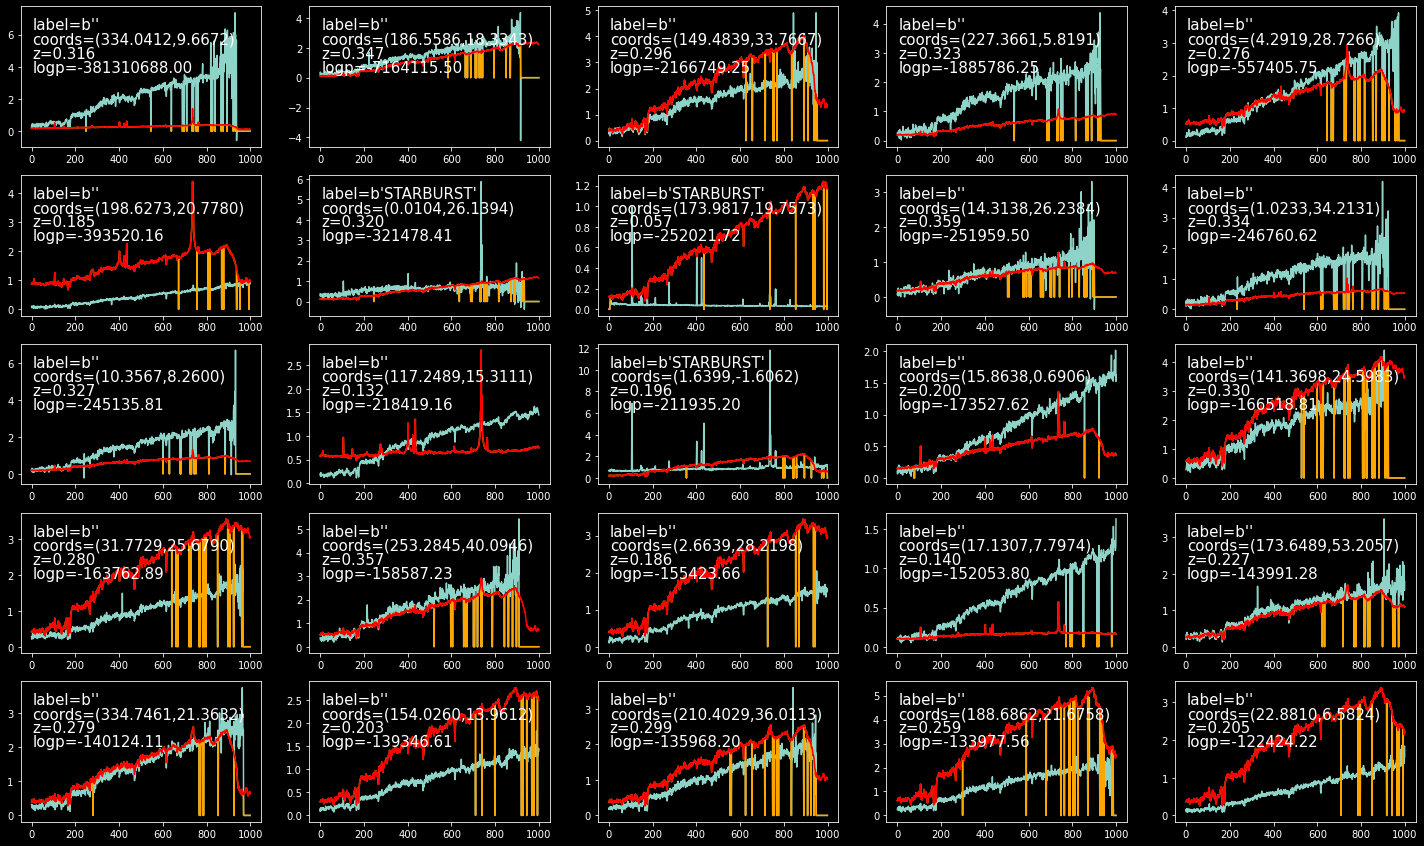

In [23]:

logps_valid = model.evaluate_density(encoded_valid).cpu()

indices = np.argsort(logps_valid)


style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(indices[0:25]):
                ax[nn].plot(new_wl,np.squeeze(valid_data)[ii]*np.squeeze(valid_mask)[ii], )
                ax[nn].plot(new_wl,np.squeeze(decoded_valid)[ii]*np.squeeze(valid_mask)[ii], color='orange')
                ax[nn].plot(new_wl,np.squeeze(decoded_valid)[ii], color='red')
                ax[nn].text(0.05, 0.92, r'label=%s'%valid_labels[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'coords=(%.4f,%.4f)'%(valid_ras[ii],valid_decs[ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.72, r'z=%.3f'%valid_params[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.62, r'logp=%.2f'%logps_valid[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()

KeyboardInterrupt: 

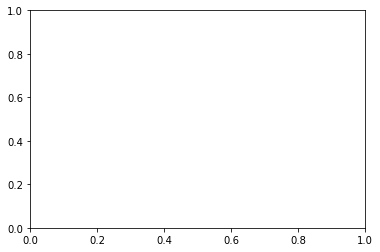

In [24]:
_ = plt.hist(logps_valid[:1000], bins=100)
#plt.show()

In [ ]:
# cluster by recon error

In [ ]:
logps_train = model.evaluate_density(encoded_train).cpu()

indices = np.argsort(logps_train)

style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(indices[0:25]):
                ax[nn].plot(new_wl[:-1], np.squeeze(train_data)[ii]*np.squeeze(train_mask)[ii], )
                ax[nn].plot(new_wl[:-1], np.squeeze(decoded_train)[ii]*np.squeeze(train_mask)[ii], color='orange')
                ax[nn].plot(new_wl[:-1], np.squeeze(decoded_train)[ii], color='red')
                ax[nn].text(0.05, 0.92, r'z=%.2f'%train_params[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'logp=%.2f'%logps_train[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()

In [ ]:
_ = plt.hist(logps_train, bins=100, density=True, log=True, cumulative=True)
